In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm

In [6]:
@dataclass
class ProcessConfig:
    """configure the data generating process"""
    type: str = 'linear'
    seq_len: int = 2000
    num_seeds: int = 3 
    num_samples_per_task: int = 100

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.type = cfg.type
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.n = cfg.num_samples_per_task
        
    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 1000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(dat[2])
            
        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        data = []
        for s in range(self.seq_len):
            x, y, t = self.generate_at_time(s, self.n)
            data.append([x, y, t])
        data = np.concatenate(data, axis=-1)
        Xdat = data[0, :].reshape(-1, 1)
        Ydat = data[1, :].astype(int)
        tind = data[2, :]
        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples, return_tensors=False):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        m = 0.1
        if self.type == 'linear':
            trend = lambda t : m * t
        elif self.type == 'quadratic':
            trend = lambda t : m * t**2
        else:
            raise ValueError(f"Unknown process type: {self.type}")

        x1 = np.random.uniform(trend(t)-11, trend(t)-10, num_samples // 2)
        x2 = np.random.uniform(trend(t)+10, trend(t)+11, num_samples // 2)

        x = np.concatenate((x1, x2))
        y = np.concatenate((np.ones(num_samples // 2), np.zeros(num_samples // 2)))

        ts = t * np.ones(num_samples)

        if return_tensors:  
            x = torch.from_numpy(x.reshape(-1, 1)).float()
            y = torch.from_numpy(y.reshape(-1)).long()
            t = torch.from_numpy(ts.reshape(-1)).float()
            return x, y, t
        else:
            return x, y, ts
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, present, run_id, test):
        x = torch.from_numpy(data['x'][run_id]).float()
        y = torch.from_numpy(data['y'][run_id]).long()
        t = torch.from_numpy(data['t'][run_id]).float()

        train_idx = torch.where(t < present)
        x_tr = x[train_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        test_idx = torch.where(t >= present)
        x_te = x[test_idx]
        y_te = y[test_idx]
        t_te = t[test_idx]
        
        if test:
            self.x = self.minimax_normalize(x_te, x_tr)
            self.t = self.minimax_normalize(t_te, t_tr)
            self.y = y_te
        else:
            self.x = self.minimax_normalize(x_tr, x_tr)
            self.t = self.minimax_normalize(t_tr, t_tr)
            self.y = y_tr

    def minimax_normalize(self, a, a_tr):
        tr_min, tr_max = a_tr.min(), a_tr.max()
        return (a - tr_min)/(tr_max - tr_min)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

In [7]:
class FourierEmbedding(nn.Module):
    """form the Fourier time-embedding"""
    def __init__(self, tdim=50):
        super(FourierEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        t = t.unsqueeze(-1)
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class PolynomialEmbedding(nn.Module):
    """form the polynomial time-embedding"""
    def __init__(self, tdim=4):
        super(PolynomialEmbedding, self).__init__()
        self.tdim = tdim

    def forward(self, t):
        t = t.unsqueeze(-1)
        return torch.cat([torch.pow(t, k) for k in range(1, self.tdim+1)], dim=-1).to(t.device)

class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, hidden_dim=[1, 32, 2], prospective=False, embedding_type='fourier', tdim=10):
        super(MLP, self).__init__()
        self.prospective = prospective
        
        if prospective:
            if embedding_type == 'fourier':
                self.embedding = FourierEmbedding(tdim)
            elif embedding_type == 'polynomial':
                self.embedding = PolynomialEmbedding(tdim)
            else:
                raise ValueError(f"Unknown embedding type: {embedding_type}")

        self.layers = nn.ModuleList()
        for i in range(len(hidden_dim)-1):
            if prospective and i == 0:
                self.layers.append(nn.Linear(hidden_dim[i] + tdim, hidden_dim[i+1]))
            else:
                self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        self.relu = nn.ReLU()

    def forward(self, x, t):
        if self.prospective:
            t = self.embedding(t)
            x = torch.cat([x, t], dim=-1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.relu(x)
        return x

In [8]:
import random

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500, return_tensors=True))

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2

    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch
            outputs = self.model(x, t)

            loss = self.criterion(outputs.squeeze(), y)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.clone().detach().item()

        return total_loss / len(self.train_loader)

    def evaluate(self, model=None):
        if model is not None:
            self.model = model
        self.model.eval()
        perrs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                perrs.append(err.detach().cpu().numpy())
        perrs = np.concatenate(perrs)
        times = self.test_loader.dataset.t.numpy()
        ploss = np.mean([np.mean(perrs[times == i]) for i in np.unique(times)])

        errs = []
        with torch.no_grad():
            for batch in self.ttest_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        iloss = np.concatenate(errs).mean()
        
        return ploss, iloss

    def train(self, num_epochs):
        progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        for epoch in progress_bar:
            train_loss = self.train_one_epoch()
            if self.verbose:
                progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}")

In [ ]:
# data generating args
seq_len = 1500
num_seeds = 1
num_samples_per_task = 20
type = 'linear'

# model args
hidden_dim = [1, 8, 8, 2]
embedding_type = 'polynomial'
tdim = 4

# training args
num_epochs = 50
lr = 0.01
criterion = nn.CrossEntropyLoss()

In [18]:
cfg = ProcessConfig(
    seq_len=seq_len,
    num_seeds=num_seeds,
    num_samples_per_task=num_samples_per_task,
    type=type
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

In [19]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# learners being considered
# methods = ["FTL", "Prospective"]
# methods = ["Prospective"]
methods = [
    {"name": "FTL", "is_prospective" : False, "embedding_type" : "None", "tdim" : 0},
    {"name": "P-MLP (fourier)", "is_prospective" : True, "embedding_type" : "fourier", "tdim" : 50},
    {"name": "P-MLP (polynomial)", "is_prospective" : True, "embedding_type" : "polynomial", "tdim" : 4},
]

t_list = np.arange(50, 800, 50) # list of time steps 

instant_risk = {} # store instant risk for each algorithm
prospective_risk = {} # store prospective risk for each algorithm

for method in methods:
    print(f"Method: {method}")
    instant_losses = []
    prospective_losses = []
    for seed in range(cfg.num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)

        iloss_list = []
        ploss_list = []
        
        for t in t_list:
            print(f"time t = {t}")

            trainloader, testloader, ttestloader = get_dataloaders(dp, t, seed)
        
            model = MLP(
                hidden_dim=hidden_dim,
                prospective=method["is_prospective"], 
                embedding_type=method["embedding_type"],
                tdim=method["tdim"]
            )
            model.to(device)

            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=lr,
                momentum=0.9, 
                nesterov=True,
                weight_decay=0.00001
            )

            trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device, verbose=True)

            if t > 2:
                trainer.train(num_epochs=num_epochs)
                
            ploss, iloss = trainer.evaluate()
            iloss_list.append(iloss)
            ploss_list.append(ploss)
            print(f"instant loss: {iloss:.4f}, prospective loss: {ploss:.4f}")

        instant_losses.append(iloss_list)
        prospective_losses.append(ploss_list)

    instant_risk[method["name"]] = np.stack(instant_losses).mean(axis=0)
    prospective_risk[method["name"]] = np.stack(prospective_losses).mean(axis=0)

Method: {'name': 'FTL', 'is_prospective': False, 'embedding_type': 'None', 'tdim': 0}
seed = 0
time t = 50


Epoch [50/50] - Loss: 0.0004: 100%|██████████| 50/50 [00:00<00:00, 53.70epoch/s]


instant loss: 0.0000, prospective loss: 0.4584
time t = 100


Epoch [50/50] - Loss: 0.0003: 100%|██████████| 50/50 [00:01<00:00, 27.33epoch/s]


instant loss: 0.0000, prospective loss: 0.4695
time t = 150


Epoch [50/50] - Loss: 0.0004: 100%|██████████| 50/50 [00:02<00:00, 18.12epoch/s]


instant loss: 0.5000, prospective loss: 0.4826
time t = 200


Epoch [50/50] - Loss: 0.0046: 100%|██████████| 50/50 [00:03<00:00, 14.62epoch/s]


instant loss: 0.5000, prospective loss: 0.4984
time t = 250


Epoch [50/50] - Loss: 0.1419: 100%|██████████| 50/50 [00:04<00:00, 11.85epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 300


Epoch [50/50] - Loss: 0.2602: 100%|██████████| 50/50 [00:05<00:00,  9.84epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 350


Epoch [50/50] - Loss: 0.3036: 100%|██████████| 50/50 [00:05<00:00,  8.50epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 400


Epoch [50/50] - Loss: 0.3921: 100%|██████████| 50/50 [00:06<00:00,  7.42epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 450


Epoch [50/50] - Loss: 0.4546: 100%|██████████| 50/50 [00:07<00:00,  6.63epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 500


Epoch [50/50] - Loss: 0.4920: 100%|██████████| 50/50 [00:08<00:00,  5.68epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 550


Epoch [50/50] - Loss: 0.4955: 100%|██████████| 50/50 [00:09<00:00,  5.41epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 600


Epoch [50/50] - Loss: 0.5041: 100%|██████████| 50/50 [00:10<00:00,  4.97epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 650


Epoch [50/50] - Loss: 0.5349: 100%|██████████| 50/50 [00:10<00:00,  4.62epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 700


Epoch [50/50] - Loss: 0.4991: 100%|██████████| 50/50 [00:11<00:00,  4.30epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
time t = 750


Epoch [50/50] - Loss: 0.5297: 100%|██████████| 50/50 [00:12<00:00,  3.93epoch/s]


instant loss: 0.5000, prospective loss: 0.5000
Method: {'name': 'P-MLP (fourier)', 'is_prospective': True, 'embedding_type': 'fourier', 'tdim': 50}
seed = 0
time t = 50


Epoch [50/50] - Loss: 0.0006: 100%|██████████| 50/50 [00:00<00:00, 53.17epoch/s]


instant loss: 0.0000, prospective loss: 0.4771
time t = 100


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:02<00:00, 24.67epoch/s]


instant loss: 0.0520, prospective loss: 0.4511
time t = 150


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:03<00:00, 16.59epoch/s]


instant loss: 0.5000, prospective loss: 0.4515
time t = 200


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:04<00:00, 12.42epoch/s]


instant loss: 0.5000, prospective loss: 0.4234
time t = 250


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:04<00:00, 10.68epoch/s]


instant loss: 0.5000, prospective loss: 0.4415
time t = 300


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:05<00:00,  9.04epoch/s]


instant loss: 0.5000, prospective loss: 0.4140
time t = 350


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:06<00:00,  7.58epoch/s]


instant loss: 0.5000, prospective loss: 0.4198
time t = 400


Epoch [50/50] - Loss: 0.0006: 100%|██████████| 50/50 [00:07<00:00,  6.87epoch/s]


instant loss: 0.5000, prospective loss: 0.3676
time t = 450


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:08<00:00,  6.06epoch/s]


instant loss: 0.5000, prospective loss: 0.3855
time t = 500


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:08<00:00,  5.60epoch/s]


instant loss: 0.5000, prospective loss: 0.3658
time t = 550


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:09<00:00,  5.13epoch/s]


instant loss: 0.5000, prospective loss: 0.3352
time t = 600


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:11<00:00,  4.41epoch/s]


instant loss: 0.5000, prospective loss: 0.3274
time t = 650


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:12<00:00,  4.04epoch/s]


instant loss: 0.5000, prospective loss: 0.2816
time t = 700


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:12<00:00,  3.94epoch/s]


instant loss: 0.5000, prospective loss: 0.2233
time t = 750


Epoch [50/50] - Loss: 0.0000: 100%|██████████| 50/50 [00:13<00:00,  3.71epoch/s]


instant loss: 0.5000, prospective loss: 0.1644
Method: {'name': 'P-MLP (polynomial)', 'is_prospective': True, 'embedding_type': 'polynomial', 'tdim': 4}
seed = 0
time t = 50


Epoch [50/50] - Loss: 0.0004: 100%|██████████| 50/50 [00:00<00:00, 52.71epoch/s]


instant loss: 0.5000, prospective loss: 0.4757
time t = 100


Epoch [50/50] - Loss: 0.0002: 100%|██████████| 50/50 [00:01<00:00, 27.14epoch/s]


instant loss: 0.5000, prospective loss: 0.4533
time t = 150


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:02<00:00, 19.10epoch/s]


instant loss: 0.5000, prospective loss: 0.4334
time t = 200


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:03<00:00, 14.26epoch/s]


instant loss: 0.5000, prospective loss: 0.4379
time t = 250


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:04<00:00, 11.29epoch/s]


instant loss: 0.5000, prospective loss: 0.3913
time t = 300


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:05<00:00,  9.41epoch/s]


instant loss: 0.5000, prospective loss: 0.4455
time t = 350


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:06<00:00,  8.10epoch/s]


instant loss: 0.5000, prospective loss: 0.4088
time t = 400


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:07<00:00,  6.94epoch/s]


instant loss: 0.5000, prospective loss: 0.3588
time t = 450


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:08<00:00,  6.24epoch/s]


instant loss: 0.5000, prospective loss: 0.3223
time t = 500


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:08<00:00,  5.66epoch/s]


instant loss: 0.5000, prospective loss: 0.2425
time t = 550


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:09<00:00,  5.21epoch/s]


instant loss: 0.5000, prospective loss: 0.1118
time t = 600


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:10<00:00,  4.76epoch/s]


instant loss: 0.5000, prospective loss: 0.2417
time t = 650


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:11<00:00,  4.43epoch/s]


instant loss: 0.5000, prospective loss: 0.1573
time t = 700


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:12<00:00,  4.13epoch/s]


instant loss: 0.5000, prospective loss: 0.1815
time t = 750


Epoch [50/50] - Loss: 0.0001: 100%|██████████| 50/50 [00:13<00:00,  3.83epoch/s]

instant loss: 0.5000, prospective loss: 0.0036


In [ ]:
# # save the results
# import pickle
# with open(f"embedding_results_{type}.pkl", "wb") as f:
#     pickle.dump({
#         "instant_risk": instant_risk,
#         "prospective_risk": prospective_risk,
#         "t_list": t_list
#     }, f)

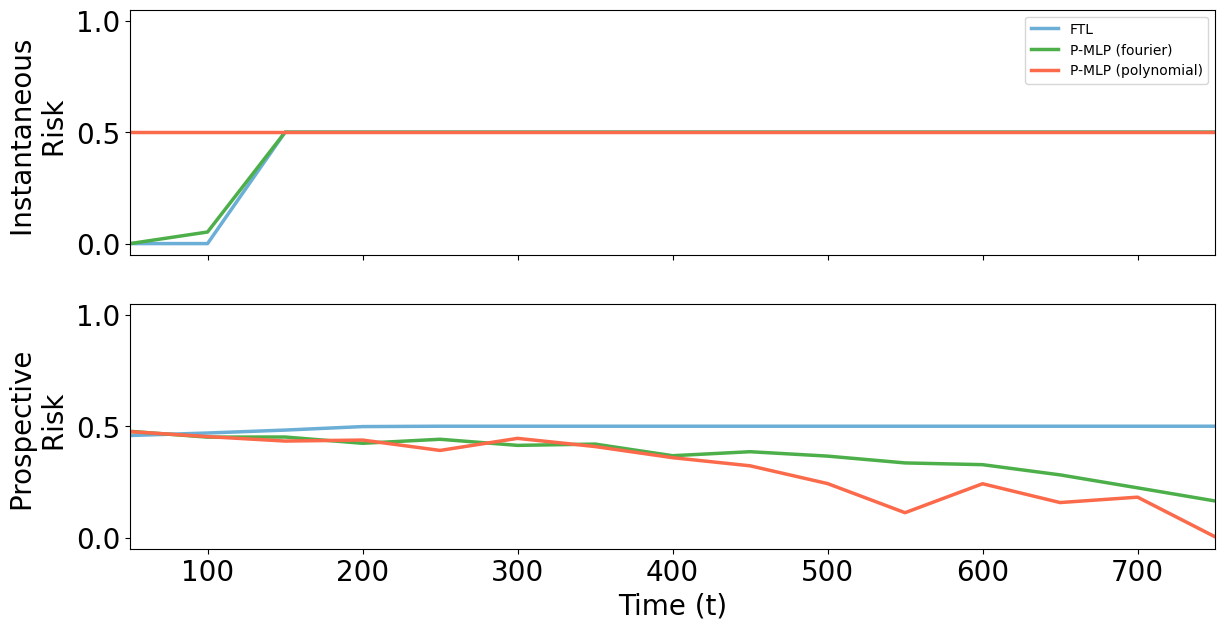

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3']

fontsize = 20
lw = 2.5

colors = ['#6baed6', '#4daf4a', '#fb6a4a']
for i, method in enumerate(methods):
    ax = axes[0]
    ax.plot(t_list, instant_risk[method["name"]], color=colors[i], lw=lw, label=method["name"])
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax = axes[1]
    ax.plot(t_list, prospective_risk[method["name"]], color=colors[i], lw=lw)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

# switch_times = np.arange(0, t_list[-1]+2, period//2)
# for i in range(0, len(switch_times)-1, 2):
#     for j in range(0, 2):
#         ax = axes[j]
#         ax.fill_betweenx([-0.1, 1.1], switch_times[i], switch_times[i+1], color='lightgray', alpha=0.2)
        
# for j in range(0, 2):
#     ax = axes[j]
#     ax.plot(t_list, np.zeros_like(t_list), lw=lw, ls='dashed', color='k', label="Bayes Risk")

# for j in range(0, 2):
#     ax = axes[j]
#     ax.plot(t_list, 0.5*np.ones_like(t_list), lw=lw, ls='dashed', color='#238b45', label="Bayes Risk")


axes[0].grid(visible=False)
axes[1].grid(visible=False)

# legend_elements = [
#     Line2D([0], [0], color='k', lw=4, ls='dashed', label='Bayes Risk'),
#     Line2D([0], [0], color='#238b45', lw=4, ls='dashed', label='Chance Risk'),
#     Line2D([0], [0], color='#6baed6', lw=4, label='FTL (homogeneous) '),
#     Line2D([0], [0], color='#fb6a4a', lw=4, label='P-MLP (homogeneous)'),
#     Line2D([0], [0], color='#377eb8', lw=4, label='FTL (heterogeneous)'),
#     Line2D([0], [0], color='#e41a1c', lw=4, label='P-MLP (heterogeneous)'),
# ]

# ax = axes[0]
# ax.legend(
#     handles=legend_elements, 
#     frameon=False, 
#     loc='upper left', 
#     bbox_to_anchor=(1, 0.55),
#     fontsize=fontsize   
# )

axes[0].set_ylabel("Instantaneous \n Risk", fontsize=fontsize)
axes[1].set_ylabel("Prospective \n Risk", fontsize=fontsize)
axes[1].set_xlabel("Time (t)", fontsize=fontsize)

axes[0].tick_params(axis='both', labelsize=fontsize)
axes[1].tick_params(axis='both', labelsize=fontsize)

axes[0].legend()

# plt.savefig(f"figures/1_effect_of_data_sparsity.pdf", bbox_inches='tight')
plt.show()

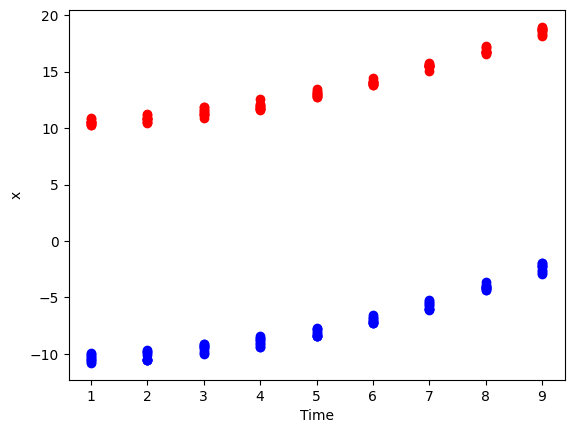

In [ ]:
x, y, t = dp.generate_sequence(1996)

for i in range(1, 10):
    indices = (t == i)
    xi = x[indices]
    ti = t[indices]
    yi = y[indices]
    plt.scatter(ti[yi == 0], xi[yi == 0], color='red')
    plt.scatter(ti[yi == 1], xi[yi == 1], color='blue')
plt.xlabel("Time")
plt.ylabel("x")
plt.show()